<a href="https://colab.research.google.com/github/DwijBishnoi/Data-Driven-Drilling-Optimization/blob/main/Proposed%20Model/Proposed_Ensembled_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Evaluation Metrics for Ensemble Model:
Mean Squared Error (MSE): 0.000003
Absolute Mean Squared Error (AMSE): 0.001075
Root Mean Squared Error (RMSE): 0.001692
R² Score: 0.998840


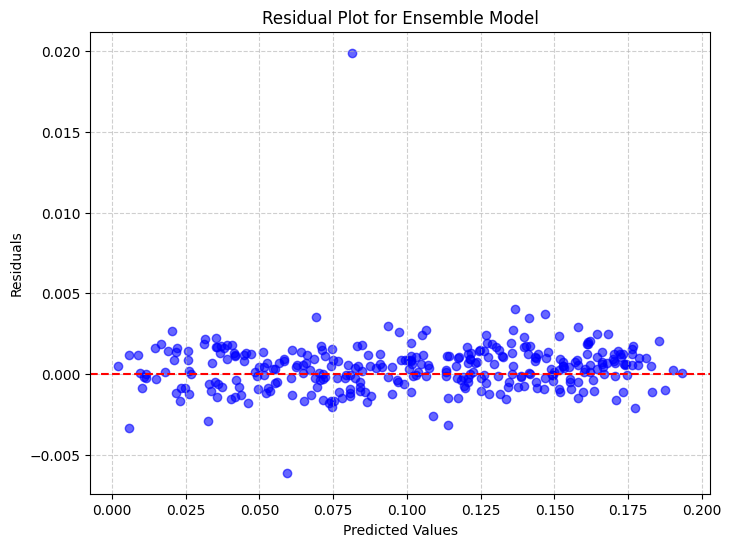

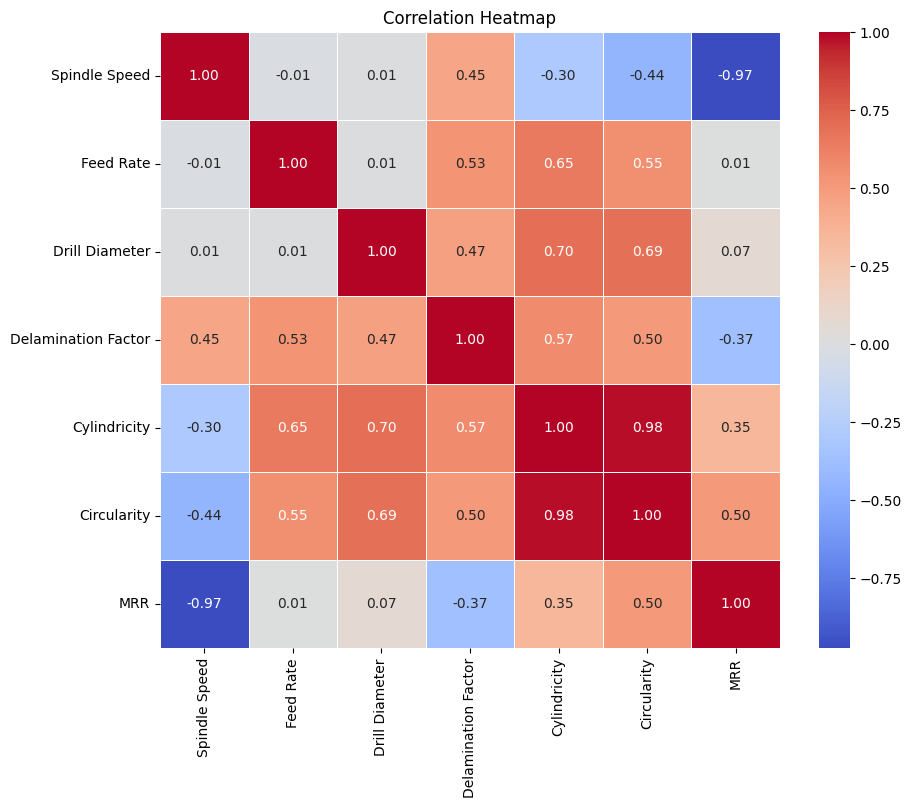

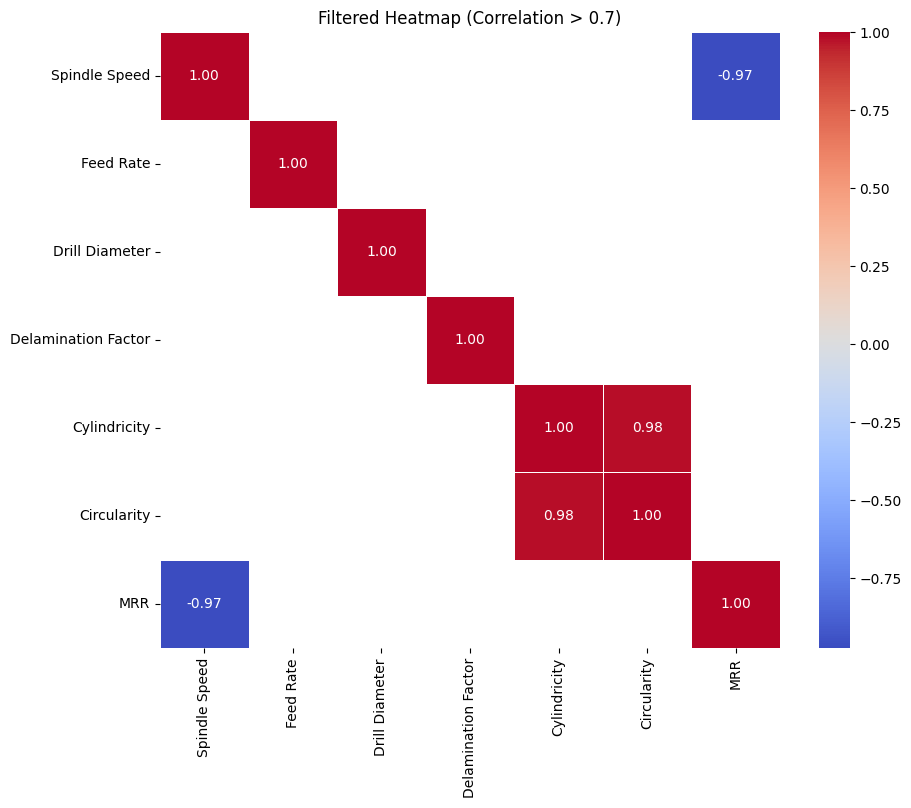

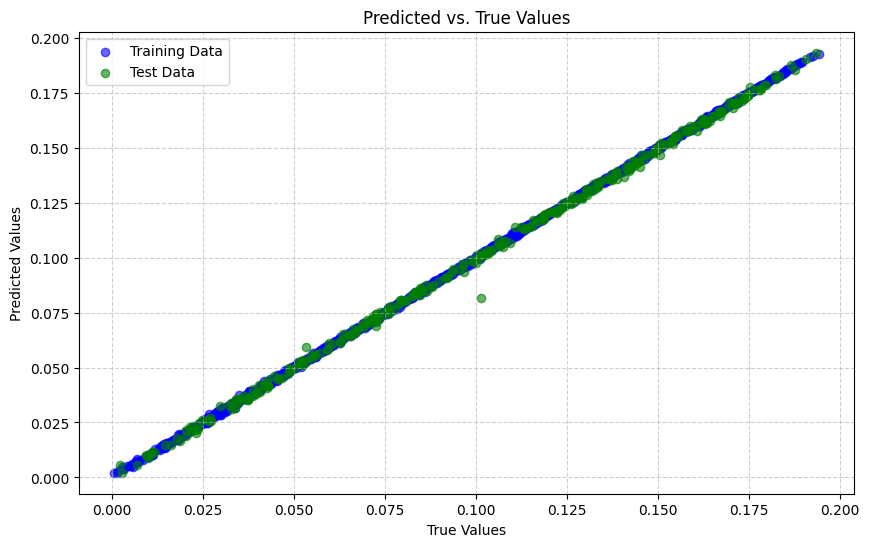

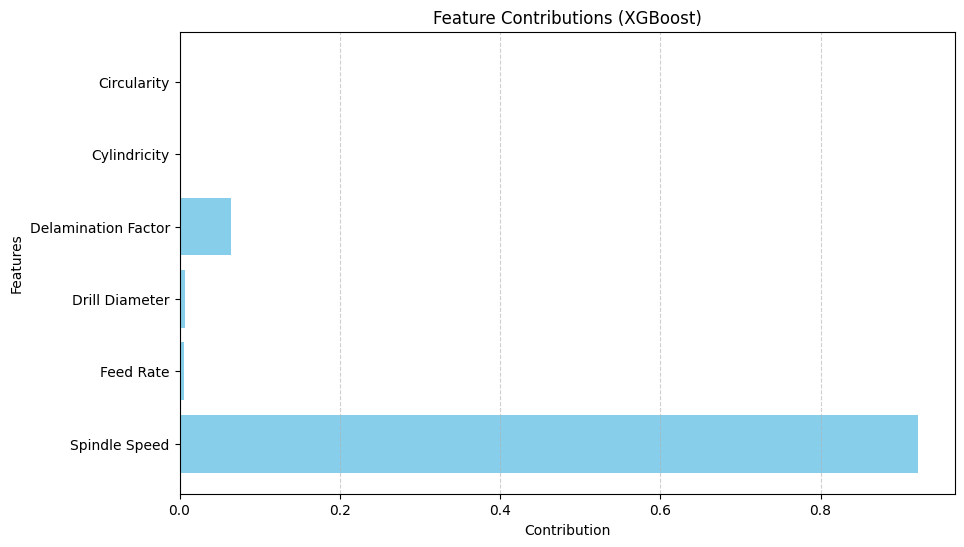

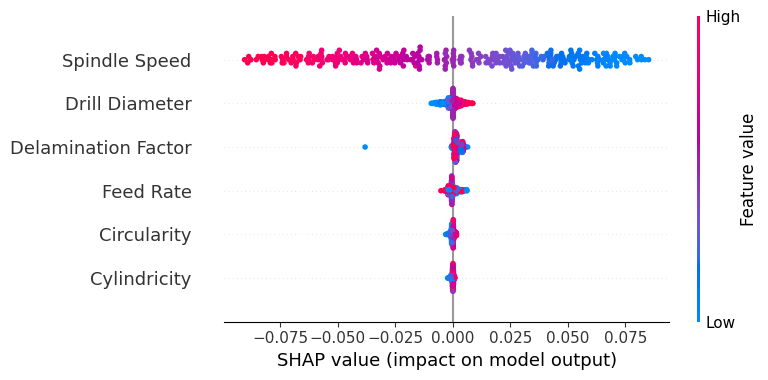

 37/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 65/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 0.08278267894842758
Prediction_local [0.11767542]
Right: 0.16213726
LIME Explanation for Test Instance 0:


<Figure size 1000x600 with 0 Axes>

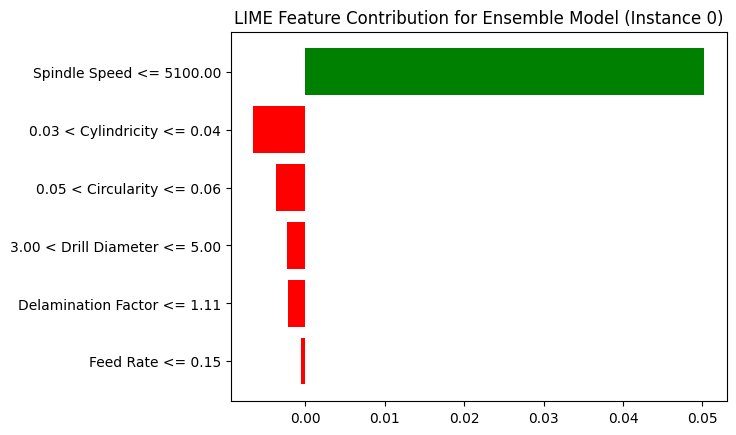

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from xgboost import XGBRegressor
import shap
from lime.lime_tabular import LimeTabularExplainer

# Load and preprocess the dataset
file_path = '/content/sample_data/Dataset_Final.xlsx'
df = pd.read_excel(file_path)

df.columns = df.iloc[1]  # Set the second row as header
df = df[2:]
df.reset_index(drop=True, inplace=True)
df = df.loc[:, df.columns.notna()]
expected_columns = ['Spindle Speed', 'Feed Rate', 'Drill Diameter',
                    'Delamination Factor', 'Cylindricity', 'Circularity', 'MRR']
if len(df.columns) == len(expected_columns):
    df.columns = expected_columns
df = df.apply(pd.to_numeric, errors='coerce').dropna()

# Feature-target split
X = df[['Spindle Speed', 'Feed Rate', 'Drill Diameter', 'Delamination Factor', 'Cylindricity', 'Circularity']]
y = df['MRR']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling for MLP and LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Individual Models
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

mlp_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(32, activation='relu'),
    Dense(1)
])
mlp_model.compile(optimizer='adam', loss='mse')
mlp_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
mlp_preds = mlp_model.predict(X_test_scaled).flatten()

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)
lstm_preds = lstm_model.predict(X_test_lstm).flatten()

# Ensemble Model
weights = {"XGBoost": 0.4, "MLP": 0.3, "LSTM": 0.3}
ensemble_preds = weights["XGBoost"] * xgb_preds + weights["MLP"] * mlp_preds + weights["LSTM"] * lstm_preds

# Metrics calculation for ensemble predictions
mse = mean_squared_error(y_test, ensemble_preds)
amse = mean_absolute_error(y_test, ensemble_preds)  # AMSE is the same as MSE for a single model
rmse = np.sqrt(mse)
r2 = r2_score(y_test, ensemble_preds)

# Print the evaluation metrics
print("Evaluation Metrics for Ensemble Model:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Absolute Mean Squared Error (AMSE): {amse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

# Residual Plot
residuals = y_test - ensemble_preds
plt.figure(figsize=(8, 6))
plt.scatter(ensemble_preds, residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot for Ensemble Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Correlation Plot
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Heatmap (Mask > 0.7)
mask = correlation_matrix.abs() < 0.7
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Filtered Heatmap (Correlation > 0.7)')
plt.show()

# Test vs. Train Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, xgb_model.predict(X_train), alpha=0.6, color='blue', label='Training Data')
plt.scatter(y_test, ensemble_preds, alpha=0.6, color='green', label='Test Data')
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Feature Contribution Plot (XGBoost)
xgb_feature_importance = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb_feature_importance, color='skyblue')
plt.title('Feature Contributions (XGBoost)')
plt.xlabel('Contribution')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# SHAP Explanation
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Define a predict function for the ensemble model
def ensemble_predict_fn(X):
    # Generate predictions using the ensemble logic
    xgboost_preds = weights["XGBoost"] * xgb_model.predict(X)
    mlp_preds = weights["MLP"] * mlp_model.predict(scaler.transform(X)).flatten()
    lstm_preds = weights["LSTM"] * lstm_model.predict(
        scaler.transform(X).reshape(X.shape[0], 1, X.shape[1])
    ).flatten()
    return xgboost_preds + mlp_preds + lstm_preds

# Create a LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode="regression",
    class_names=["MRR"],
    verbose=True
)

# Explain a specific test instance
instance_index = 0  # Change this to explain a different test instance
test_instance = X_test.iloc[instance_index].values
lime_exp = lime_explainer.explain_instance(
    data_row=test_instance,
    predict_fn=ensemble_predict_fn
)

# Plot the LIME explanation
print(f"LIME Explanation for Test Instance {instance_index}:")
lime_exp.show_in_notebook()  # For Jupyter Notebook
plt.figure(figsize=(10, 6))
lime_exp.as_pyplot_figure()
plt.title(f"LIME Feature Contribution for Ensemble Model (Instance {instance_index})")
plt.show()

